# Westeros Tutorial Part 2a.i - Introducing emissions

In the first part, the model chose not base the power system on wind power as electricity from  wind turbines was more expensive than electricity produced from coal. However, now we introduce emissions to investigate the impact of climate policy. Let's see what happens then.

**Pre-requisites**
- You have the *MESSAGEix* framework installed and working
- You have run Westeros baseline scenario (``westeros_baseline.ipynb``) and solved it successfully

In [6]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

In [7]:
mp = ixmp.Platform()

In [8]:
model = 'Westeros Electrified'

base = message_ix.Scenario(mp, model=model, scenario='baseline')
scen = base.clone(model, 'emission_bound','introducing an upper bound on emissions',
                  keep_solution=False)
scen.check_out()

In [9]:
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']
model_horizon = scen.set('year')
country = 'Westeros'

## Introducing Emissions

In [10]:
# first we introduce the emission of CO2 and the emission category GHG
scen.add_set('emission', 'CO2')
scen.add_cat('emission', 'GHG', 'CO2')

# we now add CO2 emissions to the coal powerplant
base_emission_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'unit': 'tCO2/kWa',
}

# adding new units to the model library (needed only once)
mp.add_unit('tCO2/kWa')
mp.add_unit('MtCO2')

emission_factor = make_df(base_emission_factor, technology= 'coal_ppl', emission= 'CO2', value = 7.4)
scen.add_par('emission_factor', emission_factor)

## Define a Bound on Emissions

The `type_year: cumulative` assigns an upper bound on the *weighted average of emissions* over the entire time horizon.

In [11]:
scen.add_par('bound_emission', [country, 'GHG', 'all', 'cumulative'],
             value=500., unit='MtCO2')

## Time to Solve the Model

In [12]:
scen.commit(comment='introducing emissions and setting an upper bound')
scen.set_as_default()

In [13]:
scen.solve()

In [14]:
scen.var('OBJ')['lvl']

336222.5

## Plotting Results

In [15]:
from tools import Plots
p = Plots(scen, country, firstyear=700)

### Activity

How much energy is generated in each time period from the different potential sources?

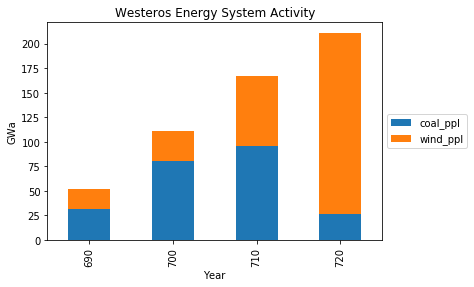

In [16]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

### Capacity

How much capacity of each plant is installed in each period?

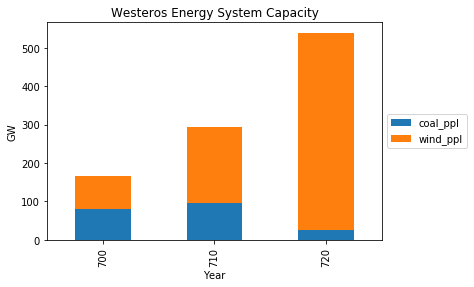

In [17]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

### Electricity Price

And how much does the electricity cost? These prices are in fact **shadow prices** taken from the **dual variables** of the model solution. They reflect the marginal cost of electricity generation (i.e., the additional cost of the system for supplying one more unit of electricity), which is in fact the marginal cost of the most expensive generator.  

Note the price drop when the most expensive technology is no longer in the system.

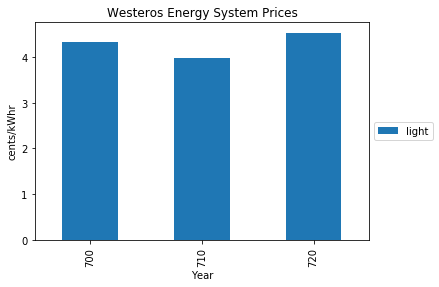

In [18]:
p.plot_prices(subset=['light'], baseyear=True)

## Close the connection to the database

In [19]:
mp.close_db()